In [1]:
import numpy as np 
import pandas as pd 

import shutil, sys  
import os
import cv2
import scipy
from skimage import io

from PIL import ImageFile
from tqdm import tqdm

In [2]:
import matplotlib.pylab as plt
from matplotlib import cm
%matplotlib inline

In [3]:
from keras.preprocessing import image as keras_image
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as inception_v3_preprocess_input

from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.
/home/edoardospinetti/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/edoardospinetti/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/edoardospinetti/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/edoardospinetti/venv/lib/python3.6/sit

In [4]:
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, BatchNormalization
from keras.layers import Activation, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D

In [5]:
def loss_plot(fit_history):
    plt.figure(figsize=(18, 4))

    plt.plot(fit_history.history['loss'], label = 'train')
    plt.plot(fit_history.history['val_loss'], label = 'test')

    plt.legend()
    plt.title('Loss Function');  

def acc_plot(fit_history):
    plt.figure(figsize=(18, 4))

    plt.plot(fit_history.history['acc'], label = 'train')
    plt.plot(fit_history.history['val_acc'], label = 'test')

    plt.legend()
    plt.title('Accuracy');
    
def path_to_tensor(img_path):
    img = keras_image.load_img("/home/edoardospinetti/Desktop/Progetto/flower_images_1/"+img_path, target_size=(128, 128))                         
    x = keras_image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

ImageFile.LOAD_TRUNCATED_IMAGES = True 

In [6]:
flowers = pd.read_csv("/home/edoardospinetti/Desktop/Progetto/flower_images_1/flower_labels.csv")
flower_files = flowers['file']
flower_targets = flowers['label'].values

Label:  9


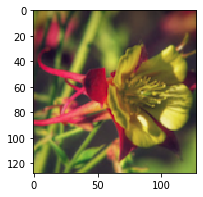

In [7]:
print('Label: ', flower_targets[168])
flower_image = cv2.imread("/home/edoardospinetti/Desktop/Progetto/flower_images_1/"+flower_files[168])
rgb_flower_image = cv2.cvtColor(flower_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(3,3))
plt.imshow(rgb_flower_image);

In [8]:
flower_tensors = paths_to_tensor(flower_files);

100%|██████████| 210/210 [00:00<00:00, 490.53it/s]


In [9]:
x_train, x_test, y_train, y_test = train_test_split(flower_tensors, flower_targets, 
                                                    test_size = 0.2, random_state = 1)
[x_train.shape, y_train.shape, x_test.shape, y_test.shape]

[(168, 128, 128, 3), (168,), (42, 128, 128, 3), (42,)]

In [10]:
n = int(len(x_test)/2)
x_valid, y_valid = x_test[:n], y_test[:n]
x_test, y_test = x_test[n:], y_test[n:]
x_train.shape, x_test.shape, x_valid.shape, y_train.shape, y_test.shape, y_valid.shape

((168, 128, 128, 3),
 (21, 128, 128, 3),
 (21, 128, 128, 3),
 (168,),
 (21,),
 (21,))

Label:  4


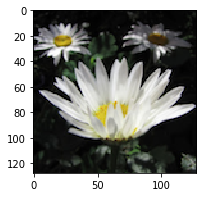

In [11]:
print('Label: ', y_train[1])
plt.figure(figsize=(3,3))
plt.imshow((x_train[1]/255).reshape(128,128,3));

In [25]:
x_train = x_train.astype(np.float32).reshape(-1, 2873*2873) / 255.0
x_test = x_test.astype(np.float32).reshape(-1, 2874*2874) / 255.0
x_valid = x_valid.astype(np.float32).reshape(-1, 2874*2874) / 255.0

c_y_train = to_categorical(y_train, 10)
c_y_test = to_categorical(y_test, 10)
c_y_valid = to_categorical(y_valid, 10)

[x_train.shape, c_y_train.shape, x_test.shape, c_y_test.shape, x_valid.shape, c_y_valid.shape]

ValueError: cannot reshape array of size 8257536 into shape (8254129)

In [13]:
# MLP
def mlp_mc_model():
    model = Sequential()
    
    model.add(Dense(128, activation='relu', input_shape=(128*128*3,)))
    model.add(BatchNormalization())
    
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization()) 
    
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))     
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

mlp_mc_model = mlp_mc_model()

W0811 19:30:45.474477 139905161779008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0811 19:30:45.508206 139905161779008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0811 19:30:45.525211 139905161779008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0811 19:30:45.659195 139905161779008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0811 19:30:45.968262 

In [14]:
mlp_mc_history = mlp_mc_model.fit(x_train.reshape(-1, 128*128*3), c_y_train,
                                  validation_data=(x_valid.reshape(-1, 128*128*3), c_y_valid),
                                  epochs=50, batch_size=64, verbose=2)

W0811 19:30:46.244549 139905161779008 deprecation.py:323] From /home/edoardospinetti/venv/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 168 samples, validate on 21 samples
Epoch 1/50
 - 2s - loss: 2.4821 - acc: 0.1548 - val_loss: 15.3506 - val_acc: 0.0476
Epoch 2/50
 - 0s - loss: 1.3324 - acc: 0.5595 - val_loss: 4.1726 - val_acc: 0.1905
Epoch 3/50
 - 0s - loss: 0.5858 - acc: 0.8155 - val_loss: 5.6137 - val_acc: 0.2381
Epoch 4/50
 - 0s - loss: 0.3001 - acc: 0.9048 - val_loss: 5.5157 - val_acc: 0.2381
Epoch 5/50
 - 0s - loss: 0.1473 - acc: 0.9583 - val_loss: 5.4777 - val_acc: 0.2857
Epoch 6/50
 - 0s - loss: 0.0942 - acc: 0.9762 - val_loss: 6.2091 - val_acc: 0.1905
Epoch 7/50
 - 0s - loss: 0.0490 - acc: 0.9940 - val_loss: 7.0366 - val_acc: 0.1429
Epoch 8/50
 - 0s - loss: 0.0184 - acc: 1.0000 - val_loss: 7.2086 - val_acc: 0.1429
Epoch 9/50
 - 0s - loss: 0.0225 - acc: 0.9940 - val_loss: 7.1818 - val_acc: 0.1429
Epoch 10/50
 - 0s - loss: 0.0076 - acc: 1.0000 - val_loss: 6.9515 - val_acc: 0.1905
Epoch 11/50
 - 0s - loss: 0.0124 - acc: 1.0000 - val_loss: 6.6670 - val_acc: 0.2381
Epoch 12/50
 - 0s - loss: 0.0048 - acc:

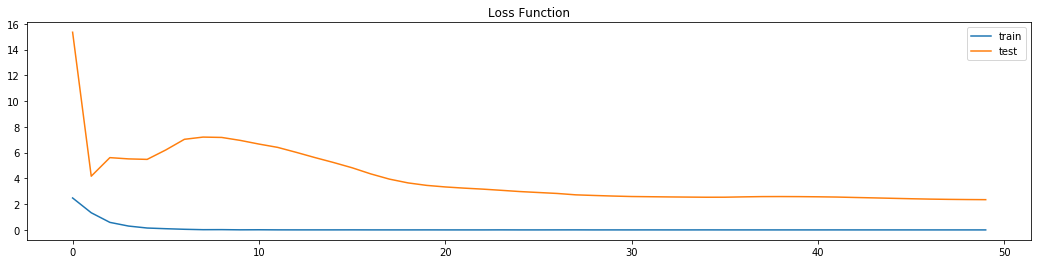

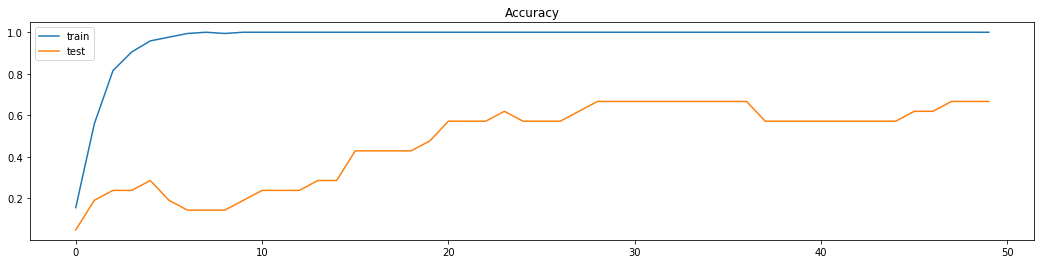

In [15]:
loss_plot(mlp_mc_history)
acc_plot(mlp_mc_history)

In [16]:
mlp_mc_test_score = mlp_mc_model.evaluate(x_test.reshape(-1, 128*128*3), c_y_test)
mlp_mc_test_score

21/21 [==============================] - 0s 386us/step


[2.172252893447876, 0.5714285969734192]

In [17]:
# CNN
def cnn_mc_model():
    model = Sequential()

    model.add(Conv2D(32, (5, 5), padding='same', input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(96, (5, 5)))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

#     model.add(Flatten())
    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(512, activation='tanh'))
    model.add(Dropout(0.25)) 
    
#    model.add(Dense(256, activation='tanh'))
#    model.add(Dropout(0.25)) 
    
    model.add(Dense(128, activation='tanh'))
    model.add(Dropout(0.25)) 

    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    
    return model

cnn_mc_model = cnn_mc_model()

W0811 19:31:03.656513 139905161779008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



In [18]:
cnn_mc_history = cnn_mc_model.fit(x_train, c_y_train, 
                                  epochs=50, batch_size=64, verbose=2,
                                  validation_data=(x_valid, c_y_valid))

Train on 168 samples, validate on 21 samples
Epoch 1/50
 - 6s - loss: 2.3453 - acc: 0.1250 - val_loss: 2.2435 - val_acc: 0.1905
Epoch 2/50
 - 5s - loss: 2.2060 - acc: 0.1964 - val_loss: 2.0047 - val_acc: 0.1905
Epoch 3/50
 - 5s - loss: 2.7663 - acc: 0.1190 - val_loss: 2.0774 - val_acc: 0.1429
Epoch 4/50
 - 5s - loss: 2.2259 - acc: 0.1369 - val_loss: 2.0827 - val_acc: 0.1905
Epoch 5/50
 - 4s - loss: 2.0377 - acc: 0.2024 - val_loss: 2.0340 - val_acc: 0.1429
Epoch 6/50
 - 4s - loss: 1.9872 - acc: 0.2262 - val_loss: 1.9633 - val_acc: 0.2857
Epoch 7/50
 - 6s - loss: 1.9373 - acc: 0.2857 - val_loss: 2.0607 - val_acc: 0.2857
Epoch 8/50
 - 5s - loss: 2.1637 - acc: 0.2440 - val_loss: 1.7751 - val_acc: 0.3810
Epoch 9/50
 - 6s - loss: 1.8593 - acc: 0.2798 - val_loss: 1.9414 - val_acc: 0.2857
Epoch 10/50
 - 5s - loss: 1.6922 - acc: 0.3929 - val_loss: 1.6861 - val_acc: 0.4286
Epoch 11/50
 - 6s - loss: 1.8191 - acc: 0.2976 - val_loss: 1.5997 - val_acc: 0.5238
Epoch 12/50
 - 5s - loss: 1.5845 - acc: 

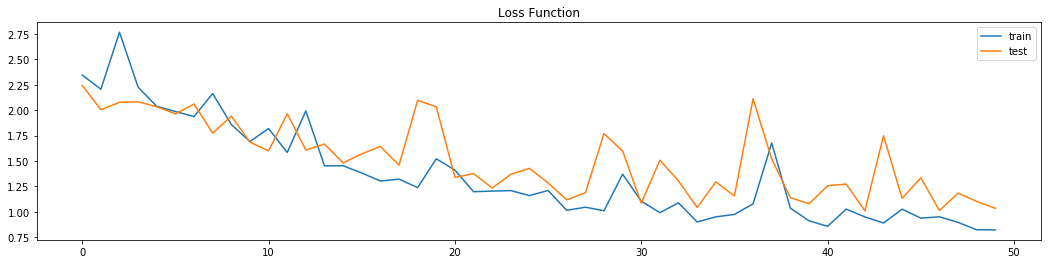

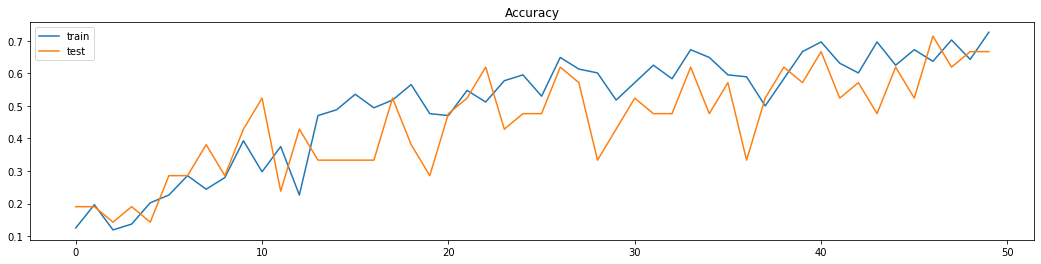

In [19]:
loss_plot(cnn_mc_history)
acc_plot(cnn_mc_history)

In [20]:
cnn_mc_test_score = cnn_mc_model.evaluate(x_test, c_y_test)
cnn_mc_test_score

21/21 [==============================] - 0s 8ms/step


[0.8349045515060425, 0.7142857313156128]